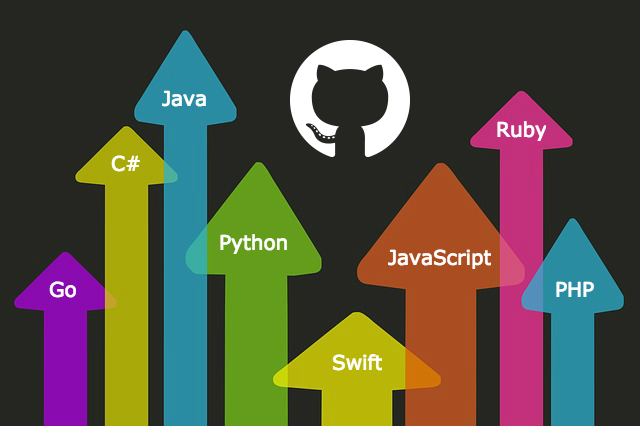

<h1><center>Natural Language Processing of Trending Github Repository READMEs </center></h1>

Corey Baughman and Caroline Miller

Codeup - Data Science

O'Neil Cohort

17 May 2023

**Project Description:** 

"Github is where over 100 million developers shape the future of software, together." 

Github provides software developers the ability to publish their own code and projects as well as explore the code of other contributors. Coding is a skill with a vast number of programming languages, libraries, and methodologies. Coding is also an art that can illustrate each developer's personal style, thought processes, and technical strengths. 

When exploring the code of other developer's to learn another tehnical skill, familiarize yourself with alternate solutions, or simply to get some inspiration, it is important to know which repositories are written in programming languages that you are working with as many are unique in functionality and syntax. 

This project aims to use Natural Language Processing tools to ultimately classify a repositories programming simply using the diction in the README. This is important because who wants to spend time opening up countless files to examine the contents and see which programming language is used. READMEs are an important aspect of any repository, and the strength of your project could be reflected in this piece of writing. If a project is useful, the README is a persuasive summary outlining the comtext and technical aspects of the project. 

**Project Goals:** 

This project uses several different skills and methods to include script writing, web scraping, regular expressions, data visualization, stastical hypothesis testing, feature engineering, text sparsing, and machibe learning modeling. The project creates a model which performs better than the baseline in predicting the programming language of a Github repository solely using the text data in the README. The project also finds significant insights about the text data itself.

#### Data Dictionary

#### Imports

In [1]:
# Modules authored by the project creators
import wrangle as w
import explore as e
import acquire as a

#### Acquire

The repositories used in this project share of the theme of being trending repositories according to Github.

The acquisition includes the text of 164 READMEs from the Github API using the requests module and BeautifulSoup. 

For the purpose of Classification, only repositories using the following three programming languages were utilized:  Python, JavaScript, and Rust.

Note: There were no null values.

#### Prepare

In [3]:
# Using the wrangle module, the webscraping functions from the acquire module
# produce the following raw dataframe.
df = w.acquire_github_data()
df.head(3)

,repo,language,readme_contents
0,./WebGoat/WebGoat,JavaScript,# WebGoat 8: A deliberately insecure Web Appli...
1,./vercel/next-react-server-components,JavaScript,# Next.js App Router + React Server Components...
2,./LaurentMazare/tch-rs,Rust,# tch-rs\nRust bindings for the C++ api of PyT...


The wrangle module uses the following steps to clean the README contents:

    1. lower()
    2. unicodedata.normalize to remove any inconsistencies in unicode character encoding
    3. .encode to convert the resulting string to the ASCII character set
    4. .decode to turn the resulting bytes object back into a string
    5. regular expressions cpture groups to isolate words and numbers
    6. tokenize to break words and any punctuation left over into discrete units
    7. lemmatize to keep only the root words
    8. remove stopwords as listed in the english dictionary (according to nltk.corpus)

The following features are engineered:

    1. count of stopwords
    2. ratio of stopwords to all words
    3. calcualtion of sentiment
    4. number of unique words
    5. ratio of unique words to all words